In [1]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from astropy.io import fits

from scipy.optimize import curve_fit, Bounds

pd.set_option('display.max_columns', None)

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# New data structure for spectral lines
spectral_line_groups = {
    'Hydrogen_Balmer': {
        'color': 'red',
        'lines': {
            6563: 'H-alpha',    # Transition from n=3 to n=2
            4861: 'H-beta',     # Transition from n=4 to n=2
            4341: 'H-gamma',    # Transition from n=5 to n=2
            4102: 'H-delta',    # Transition from n=6 to n=2
            3970: 'H-epsilon',  # Transition from n=7 to n=2
            3889: 'H-zeta',     # Transition from n=8 to n=2
            3835: 'H-eta',      # Transition from n=9 to n=2
            3798: 'H-8'         # Transition from n=10 to n=2

        }
    },
    'He_I': {
        'color': 'blue',
        'lines': {
            4471: 'He I 4471',  # He I line at 4471 Å
            4026: 'He I 4026',  # He I line at 4026 Å
            5876: 'He I 5876',  # He I line at 5876 Å
            6678: 'He I 6678',  # He I line at 6678 Å
            7065: 'He I 7065'   # He I line at 7065 Å
        }
    },
    'He_II': {
        'color': 'green',
        'lines': {
            4686: 'He II 4686',
            5411: 'He II 5411'
        }
    },
    'Telluric': {
        'color': 'grey',
        'lines': {
            6867: 'O₂ B-band',  # Around 6867 Å, another strong telluric oxygen band
            7594: 'O₂ A-band',  # Around 7600 Å, the strong telluric oxygen band you mentioned
            # Add more telluric lines as needed
        }
    }
    # Add more groups as needed
}


In [3]:
def extract_wavelength_and_flux(fits_file):
    with fits.open(fits_file) as hdulist:
        # Extracting header information
        header = hdulist[0].header
        crval1 = header['CRVAL1']
        crpix1 = header['CRPIX1']
        cdelt1 = header['CDELT1']
        
        # Calculating the wavelength array
        index = np.arange(header['NAXIS1'])
        wavelength = crval1 + (index - crpix1) * cdelt1

        # Extracting flux data
        flux = hdulist[0].data

    return wavelength, flux, header['OBJNAME']

def wavelength_to_rgb(wavelength, gamma=0.8):
    """ This function converts a wavelength in nanometers to an RGB color. """
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = G = B = 0.0
    return (R, G, B)

def fit_blackbody_curve(wavelength, flux):
    # Initial guess for temperature and scale
    temp_guess = 10000
    initial_guess = [temp_guess, 1]
    flux_units = u.erg/u.s/u.cm**2/u.AA

    # Bounds for the curve fitting
    bounds = ((0, -np.inf), (np.inf, np.inf))  # Setting lower bound of temperature to a small positive value

    def blackbody_function(wavelength, temp, scale):
        """ Blackbody as a function of wavelength and parameters. """
        wavelength = wavelength * u.AA
        bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
        return bb(wavelength).value

    # Curve fitting
    params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)
    fitted_temperature, fitted_scale = params_opt

    # Creating the fitted blackbody curve
    fitted_temperature *= u.K
    bb = BlackBody(temperature=fitted_temperature, scale=fitted_scale*flux_units/u.sr)
    bb_curve = bb(wavelength*u.AA).value

    return bb_curve, fitted_temperature, fitted_scale

def plot_spectra(wavelength, flux, bb_curve, groups_to_plot, spectral_line_groups, object_name='Star'):
    plt.figure(figsize=(15, 10))
    plt.plot(wavelength, flux, color='blue', label='Observed Spectrum')
    
    if bb_curve is not None:
        plt.plot(wavelength, bb_curve, color='orange', label='Blackbody Fit')


    # Plot and label spectral lines for each selected group
    wavelength_min, wavelength_max = wavelength.min(), wavelength.max()
    if groups_to_plot is not None:
        for group in groups_to_plot:
            group_info = spectral_line_groups.get(group, {})
            group_color = group_info.get('color', 'black')
            for wl, label in group_info.get('lines', {}).items():
                if wavelength_min <= wl <= wavelength_max:
                    plt.axvline(x=wl, color=group_color, linestyle='--')
                    plt.text(wl, plt.ylim()[1]*0.85, label, rotation=90, color='black', fontsize=12)  # Increased font size

    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Spectral Data for ' + object_name)
    plt.grid(True)
    plt.legend()

    # Create a small band at the bottom for the visible spectrum
    band_height = 0.05 * (plt.ylim()[1] - plt.ylim()[0])
    for wl in range(int(wavelength_min), int(wavelength_max)):
        color = wavelength_to_rgb(wl/10)
        rect = patches.Rectangle((wl, plt.ylim()[0]), 1, band_height, color=color)
        plt.gca().add_patch(rect)

    plt.xlim([wavelength_min, wavelength_max])
    plt.show()


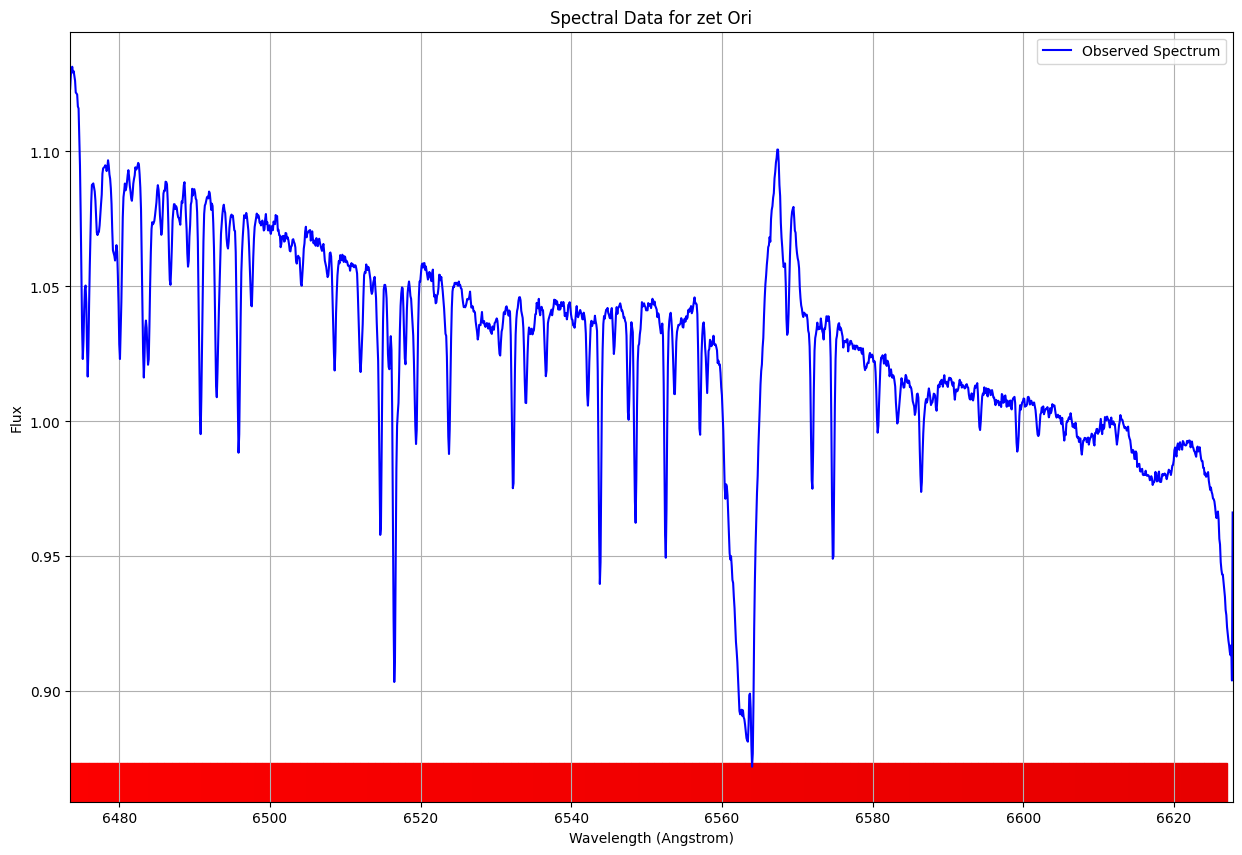

Fitted Temperature: None
Fitted Amplitude: None


In [5]:
fits_file = "spectra/O-Alnitak-zet-Ori-6500.fits"
wavelength, flux, object_name = extract_wavelength_and_flux(fits_file)

bb_curve, fitted_temperature, fitted_scale = None, None, None
#bb_curve, fitted_temperature, fitted_scale = fit_blackbody_curve(wavelength, flux)

groups_to_plot = None#['Hydrogen_Balmer']
plot_spectra(wavelength, flux, bb_curve, groups_to_plot, spectral_line_groups, object_name=object_name)

print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)